In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import healpy as hp
import reproject
import numpy as np
from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from spectral_cube import SpectralCube
from reproject import reproject_from_healpix
import warnings


This notebook plots CHIME+GMIMS and Dragons+GMIMS spectra with the Burn and Tribble depolarization models fit using scipy_optimize. This includes no Faraday depth modeling. QU-Fitting is preferred to the method used here.

### Import the datasets to be used

In [11]:
#-- GMIMS and CHIME polarized intensity (pI) data
gmims_cube = SpectralCube.read('/srv/nmohamme/fanregionII/data/GMIMS-HBN_fanregion_cutout_pI.fits', format='fits')
wcs_hbn = gmims_cube.wcs
chime_cube = SpectralCube.read('/srv/nmohamme/fanregionII/data/chimepI_kelvin_tadpolecutout.fits')
drago_cube = SpectralCube.read('/srv/nmohamme/fanregionII/data/dragons_pI_kelvin.fits')
file_path = '/srv/data/dragons/Mar2024_500_1000_MHz_cube/ListOfFrequencies_Hz.txt'
with open(file_path, 'r') as f:
    drag_freq = np.loadtxt(f)

In [12]:
gmims_glon = wcs_hbn.wcs_pix2world(np.arange(1,gmims_cube.header['NAXIS1']+1), [100], [100], 1)[0]*u.deg
gmims_glat = wcs_hbn.wcs_pix2world([100],np.arange(1,gmims_cube.header['NAXIS2']+1), [100], 1)[1]*u.deg

In [13]:
fn = '/home/nmohamme/FanRegionII/WMAP_data/wmap_band_iqumap_r9_9yr_K_v5.fits'
WMAP_data = fits.getdata(fn, exten_no=1)
glon_grid, glat_grid = np.meshgrid(gmims_glon, gmims_glat)
coords = SkyCoord(glon_grid.ravel(), glat_grid.ravel(), frame='galactic', unit='deg')

In [14]:
#Obtaining the WMAP data on the same WCS as gmims
wmapQ23, footprint= reproject_from_healpix((WMAP_data['Q_POLARISATION'],'galactic'),
                                     wcs_hbn.celestial, shape_out=np.shape(glon_grid),
                                     nested=True)*u.mK
wmapU23, footprint= reproject_from_healpix((WMAP_data['U_POLARISATION'],'galactic'),
                                     wcs_hbn.celestial, shape_out=np.shape(glon_grid),
                                     nested=True)*u.mK
wmap_pI = np.sqrt(wmapU23**2+wmapQ23**2)

### Plotting Spectra

In [15]:
#This is the burn depolarization function
def burn_depol(freqHz, alpha, sigma):
    f= freqHz
    T = wmap_pI[int((wcs_hbn.wcs_world2pix((c.l.value),c.b.value, 1, 1))[0]),int((wcs_hbn.wcs_world2pix((c.l.value),c.b.value, 1, 1))[1])].to(u.Jy/u.sr, equivalencies=u.brightness_temperature(np.asarray([22.8])*u.GHz)).value
    s =  sigma
    exponent=alpha
    powerlaw=T*(f/22.8)**(-1*exponent)
    lambArr = (f*u.GHz).to(u.m, equivalencies=u.spectral()).value
    p = np.exp(-2*lambArr**4*s**2)
    return powerlaw*p

In [16]:
def tribble_depol(freqHz, alpha, sigma,N):
    f= freqHz
    T = wmap_pI[int((wcs_hbn.wcs_world2pix((c.l.value),c.b.value, 1, 1))[0]),int((wcs_hbn.wcs_world2pix((c.l.value),c.b.value, 1, 1))[1])].to(u.Jy/u.sr, equivalencies=u.brightness_temperature(np.asarray([22.8])*u.GHz)).value
    s = sigma
    exponent=alpha
    powerlaw=T*(f/22.8)**(-1*exponent)
    lambArr = (f*u.GHz).to(u.m, equivalencies=u.spectral()).value
    p = N**(-0.5)/(s*lambArr**2*2*np.sqrt(2))
    return powerlaw*p

In [17]:
def powerlaw(freqHz, alpha):
    f= freqHz
    T = wmap_pI[int((wcs_hbn.wcs_world2pix((c.l.value),c.b.value, 1, 1))[0]),int((wcs_hbn.wcs_world2pix((c.l.value),c.b.value, 1, 1))[1])].to(u.Jy/u.sr, equivalencies=u.brightness_temperature(np.asarray([22.8])*u.GHz)).value
    exponent=alpha
    powerlaw=T*(f/22.8)**(-1*exponent)
    return powerlaw

In [18]:
#list of sightlines to plot
clist = SkyCoord([134,134.5,134.8,134]*u.deg, [15.0,8.3,4.0,0.0]*u.deg, frame='galactic')

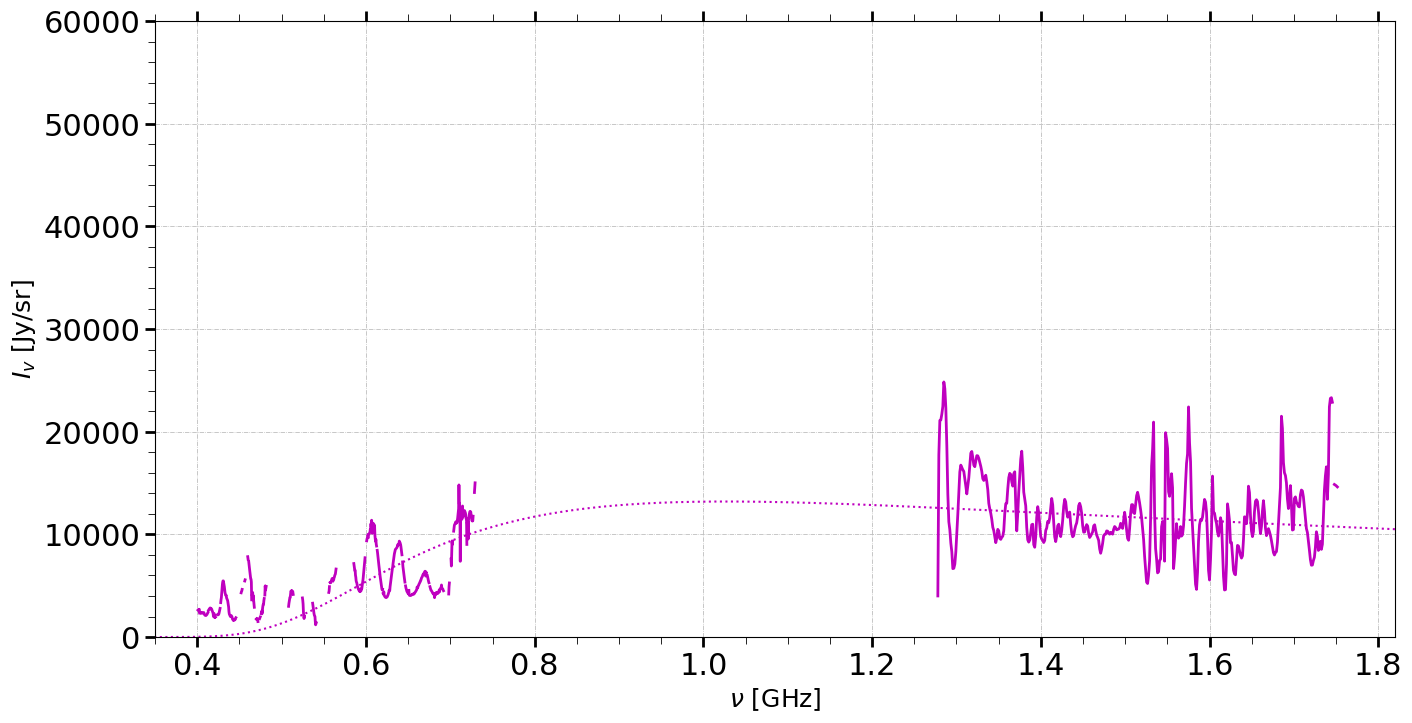

In [19]:
# Suppress specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='All-NaN slice encountered')
warnings.filterwarnings('ignore', category=UserWarning, message='Slicing across a celestial axis results in an invalid WCS')
warnings.filterwarnings('ignore', category=UserWarning, message='This function .* requires loading the entire cube into memory and may therefore be slow.')

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
freq_all = np.arange(1, 1.8e9, 1e6) # an array spanning the frequencies looked at from chime to GMIMS (not WMAP)
all_v = np.arange(1e-3, 2, 1e-3)

region=(40*u.arcmin).to(u.deg)
#for c, color, in zip(clist, ['y', 'k', 'c', 'm']):
c = clist[0]
color = 'm'

beam_gmims = gmims_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)
gmims_spectrum_K = np.median(beam_gmims.with_mask(beam_gmims>0.05*u.K).median(axis=1).value, axis=1)*beam_gmims.unit
gmims_spectrum_Jy_sr = gmims_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(beam_gmims.spectral_axis))

beam_chime = chime_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)*u.K
chime_spectrum_K = np.median(beam_chime.with_mask(beam_chime>0.05*u.K).median(axis=1).value, axis=1)*beam_chime.unit
chime_spectrum_Jy_sr = chime_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(beam_chime.spectral_axis))

full_v=np.concatenate((beam_chime.spectral_axis.to(u.GHz).value,beam_gmims.spectral_axis.to(u.GHz).value))
full_Iv = np.concatenate((chime_spectrum_Jy_sr, gmims_spectrum_Jy_sr))

nan_mask = ~np.isnan(full_v) & ~np.isnan(full_Iv)
filtered_Hz = full_v[nan_mask]
filtered_Iv = full_Iv[nan_mask]
popt, pcov = curve_fit(burn_depol,filtered_Hz,filtered_Iv, bounds=([0,0], [5, np.inf]))


ax.plot(all_v, burn_depol(all_v, *popt), ls='dotted', c=color)

ax.plot(beam_gmims.spectral_axis.to(u.GHz), gmims_spectrum_Jy_sr, c=color, lw=2)
ax.plot(beam_chime.spectral_axis.to(u.GHz), chime_spectrum_Jy_sr, c=color, lw=2)

ax.set_ylim(0,60000)
ax.set_xlim(0.35, 1.82)


ax.set_ylabel(r'$I_v$ [Jy/sr]', fontsize=18)
ax.set_xlabel(r'$\nu$ [GHz]', fontsize=18)

ax.minorticks_on()  # Enable minor ticks for the first subplot
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
#plt.legend(fontsize=18)

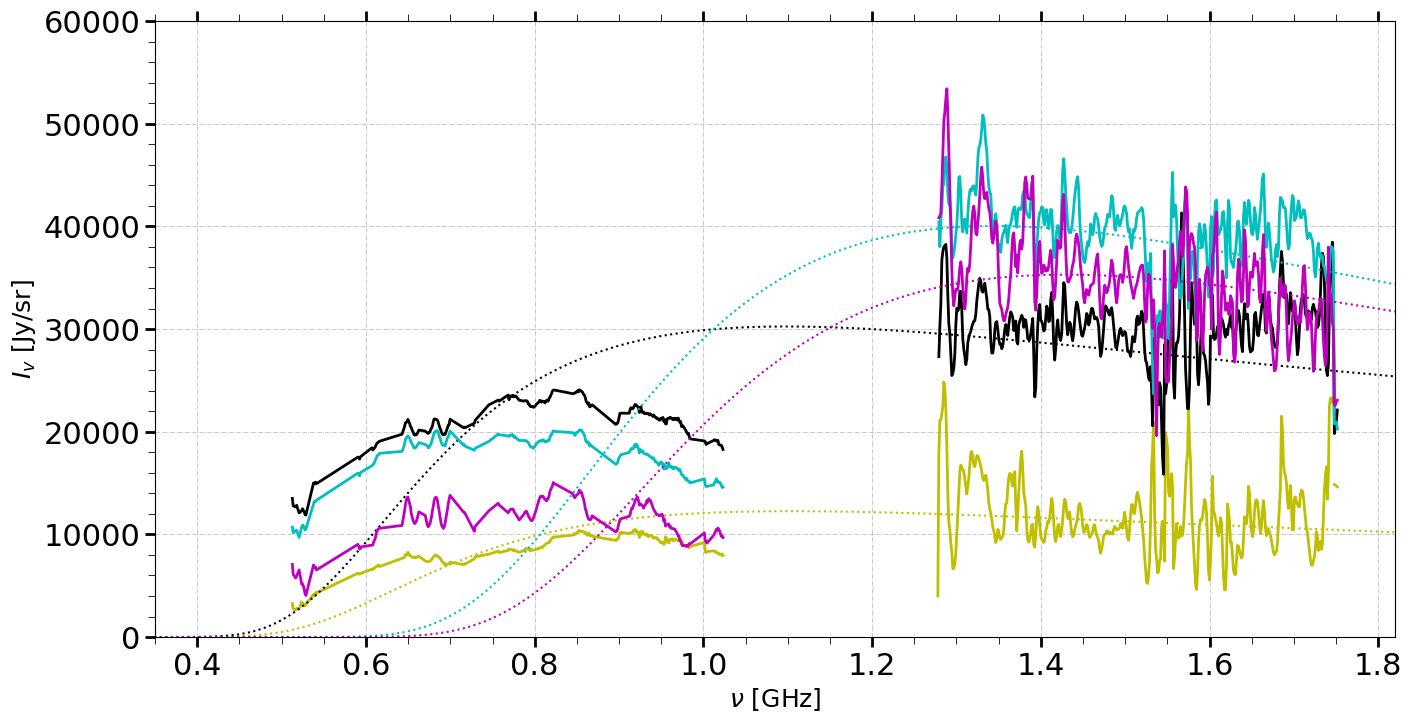

In [20]:
# Suppress specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='All-NaN slice encountered')
warnings.filterwarnings('ignore', category=UserWarning, message='Slicing across a celestial axis results in an invalid WCS')
warnings.filterwarnings('ignore', category=UserWarning, message='This function .* requires loading the entire cube into memory and may therefore be slow.')

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
freq_all = np.arange(1, 1.8e9, 1e6) # an array spanning the frequencies looked at from chime to GMIMS (not WMAP)
all_v = np.arange(1e-3, 2, 1e-3)

region=(40*u.arcmin).to(u.deg)
region_2=(2.4*u.deg)
for c, color, in zip(clist, ['y', 'k', 'c', 'm']):

    beam_gmims = gmims_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                  ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)
    gmims_spectrum_K = np.median(beam_gmims.with_mask(beam_gmims>0.05*u.K).median(axis=1).value, axis=1)*beam_gmims.unit
    gmims_spectrum_Jy_sr = gmims_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(beam_gmims.spectral_axis))

    beam_drago = drago_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                    ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)/u.Jy*u.beam*u.K
    drago_spectrum_K = np.median(beam_drago.with_mask(beam_drago>0.05*u.K).median(axis=1).value, axis=1)*beam_drago.unit
    drago_spectrum_Jy_sr = drago_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(drag_freq*u.Hz))

    full_v=np.concatenate(((drag_freq*u.Hz).to(u.GHz).value,beam_gmims.spectral_axis.to(u.GHz).value))
    full_Iv = np.concatenate((drago_spectrum_Jy_sr, gmims_spectrum_Jy_sr))

    nan_mask = ~np.isnan(full_v) & ~np.isnan(full_Iv)
    filtered_Hz = full_v[nan_mask]
    filtered_Iv = full_Iv[nan_mask]
    popt, pcov = curve_fit(burn_depol,filtered_Hz,filtered_Iv, bounds=([0,0], [5, np.inf]))
    

    ax.plot(all_v, burn_depol(all_v, *popt), ls='dotted', c=color)

    ax.plot(beam_gmims.spectral_axis.to(u.GHz), gmims_spectrum_Jy_sr, c=color, lw=2)
    ax.plot(drag_freq*u.Hz.to(u.GHz), drago_spectrum_Jy_sr, c=color, lw=2)

ax.set_ylim(0,60000)
ax.set_xlim(0.35, 1.82)
    

ax.set_ylabel(r'$I_v$ [Jy/sr]', fontsize=18)
ax.set_xlabel(r'$\nu$ [GHz]', fontsize=18)

ax.minorticks_on()  # Enable minor ticks for the first subplot
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
#plt.legend(fontsize=18)

In [57]:
clist = SkyCoord([np.random.uniform(low=130, high=140),np.random.uniform(low=130, high=140),np.random.uniform(low=130, high=140),np.random.uniform(low=130, high=140)]*u.deg,
                 [np.random.uniform(low=0, high=10),np.random.uniform(low=0, high=10),np.random.uniform(low=0, high=10),np.random.uniform(low=0, high=10)]*u.deg, frame='galactic')

In [58]:
clist

<SkyCoord (Galactic): (l, b) in deg
    [(135.31335612, 5.48682871), (137.59301989, 4.32790113),
     (135.2127506 , 4.72124298), (137.33334124, 8.89808999)]>

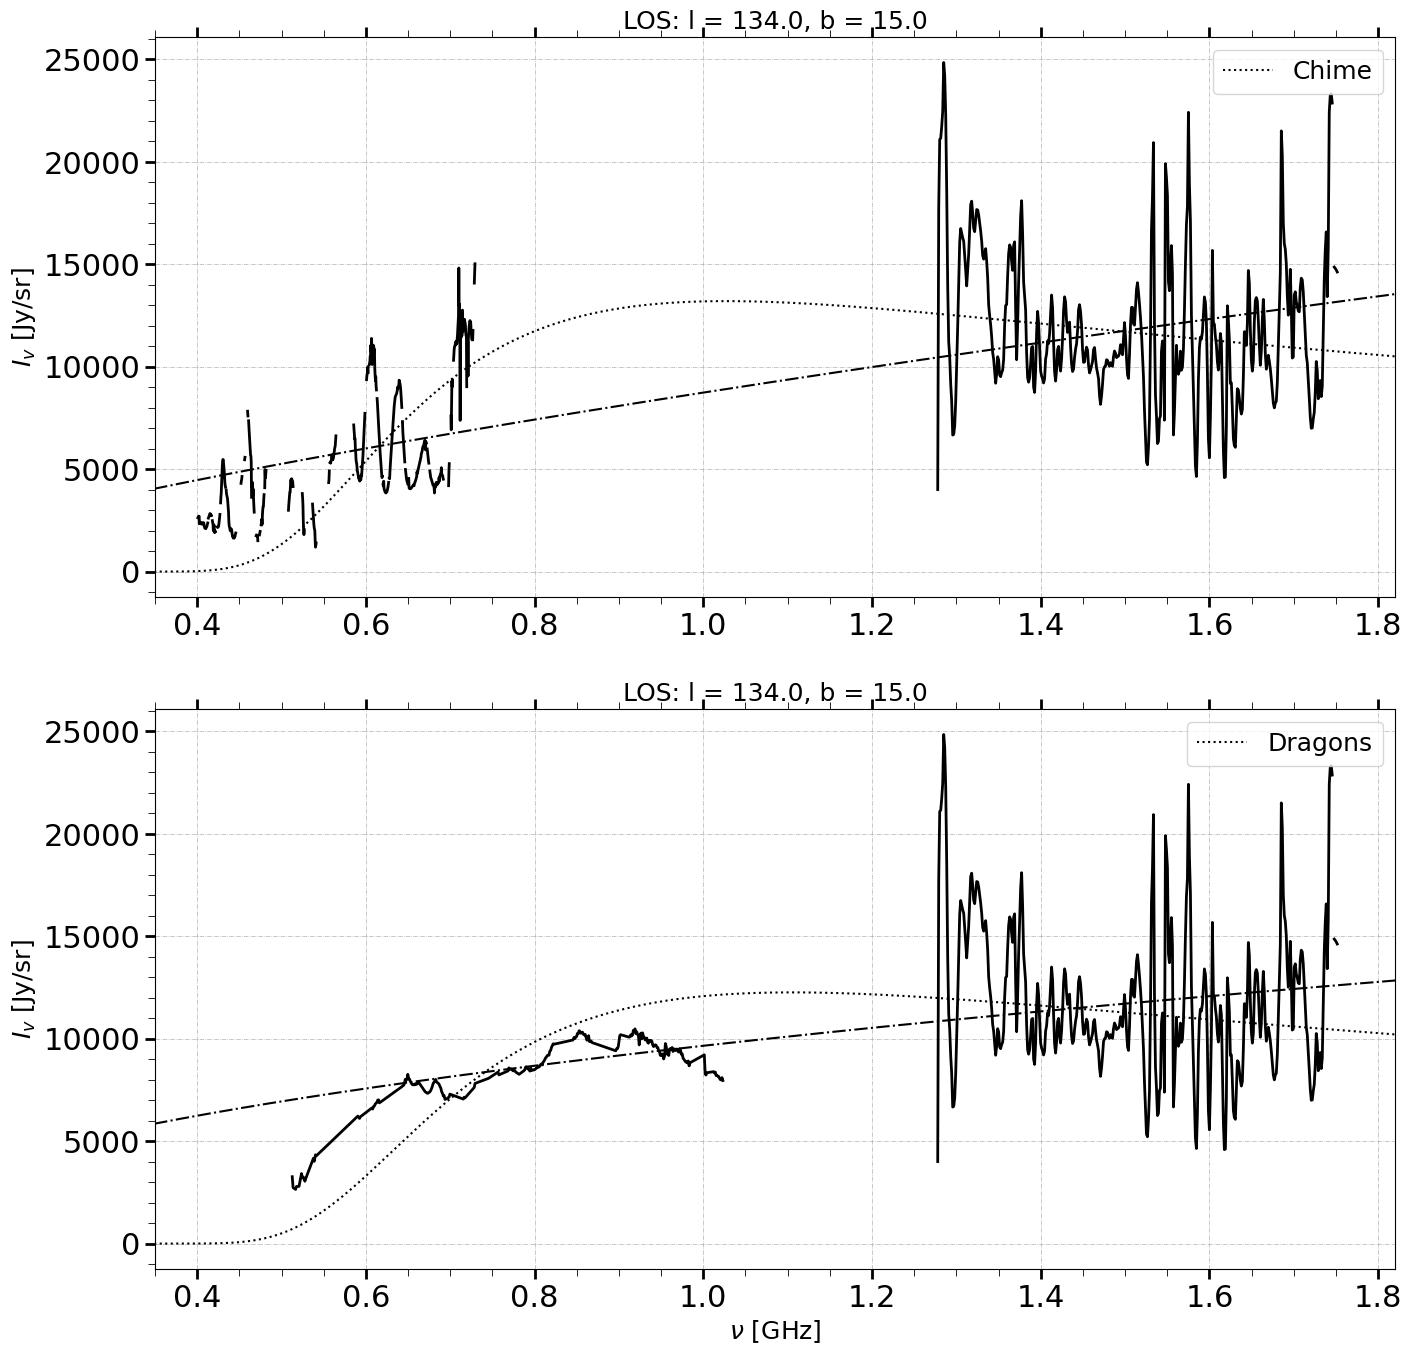

In [21]:
# Suppress specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='All-NaN slice encountered')
warnings.filterwarnings('ignore', category=UserWarning, message='Slicing across a celestial axis results in an invalid WCS')
warnings.filterwarnings('ignore', category=UserWarning, message='This function .* requires loading the entire cube into memory and may therefore be slow.')

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(211)
freq_all = np.arange(1, 1.8e9, 1e6) # an array spanning the frequencies looked at from chime to GMIMS (not WMAP)
all_v = np.arange(1e-3, 2, 1e-3)

region=(40*u.arcmin).to(u.deg)
#for c, color, in zip(clist, ['y', 'k', 'c', 'm']):
c = clist[0]
color = 'k'

beam_gmims = gmims_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)
gmims_spectrum_K = np.median(beam_gmims.with_mask(beam_gmims>0.05*u.K).median(axis=1).value, axis=1)*beam_gmims.unit
gmims_spectrum_Jy_sr = gmims_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(beam_gmims.spectral_axis))

beam_chime = chime_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)*u.K
chime_spectrum_K = np.median(beam_chime.with_mask(beam_chime>0.05*u.K).median(axis=1).value, axis=1)*beam_chime.unit
chime_spectrum_Jy_sr = chime_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(beam_chime.spectral_axis))

full_v=np.concatenate((beam_chime.spectral_axis.to(u.GHz).value,beam_gmims.spectral_axis.to(u.GHz).value))
full_Iv = np.concatenate((chime_spectrum_Jy_sr, gmims_spectrum_Jy_sr))

nan_mask = ~np.isnan(full_v) & ~np.isnan(full_Iv)
filtered_Hz = full_v[nan_mask]
filtered_Iv = full_Iv[nan_mask]
popt, pcov = curve_fit(burn_depol,filtered_Hz,filtered_Iv, bounds=([0,0], [5, np.inf]))
poptr, pcovr = curve_fit(tribble_depol, filtered_Hz, filtered_Iv, bounds=([0,0,0], [5, np.inf, np.inf]))


ax.plot(all_v, burn_depol(all_v, *popt), ls='dotted', c=color, label='Chime')
ax.plot(all_v, tribble_depol(all_v,*poptr), ls= '-.', c=color)

ax.plot(beam_gmims.spectral_axis.to(u.GHz), gmims_spectrum_Jy_sr, c=color, lw=2)
ax.plot(beam_chime.spectral_axis.to(u.GHz), chime_spectrum_Jy_sr, c=color, lw=2)

#ax.set_ylim(0,60000)
ax.set_xlim(0.35, 1.82)

ax.set_title(f'LOS: l = {round(c.galactic.l.value,2)}, b = {round(c.galactic.b.value,2)}', fontsize=18)
ax.set_ylabel(r'$I_v$ [Jy/sr]', fontsize=18)
#ax.set_xlabel(r'$\nu$ [GHz]', fontsize=18)

ax.minorticks_on()  # Enable minor ticks for the first subplot
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
plt.legend(fontsize=18)

############## - adding dragons to plot
ax = fig.add_subplot(212)
beam_drago = drago_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)/u.Jy*u.beam*u.K
drago_spectrum_K = np.median(beam_drago.with_mask(beam_drago>0.05*u.K).median(axis=1).value, axis=1)*beam_drago.unit
drago_spectrum_Jy_sr = drago_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(drag_freq*u.Hz))

full_v=np.concatenate(((drag_freq*u.Hz).to(u.GHz).value,beam_gmims.spectral_axis.to(u.GHz).value))
full_Iv = np.concatenate((drago_spectrum_Jy_sr, gmims_spectrum_Jy_sr))

nan_mask = ~np.isnan(full_v) & ~np.isnan(full_Iv)
filtered_Hz = full_v[nan_mask]
filtered_Iv = full_Iv[nan_mask]
popt, pcov = curve_fit(burn_depol,filtered_Hz,filtered_Iv, bounds=([0,0], [5, np.inf]))
poptr, pcovr = curve_fit(tribble_depol, filtered_Hz, filtered_Iv, bounds=([0,0,0], [5, np.inf, np.inf]))


ax.plot(all_v, burn_depol(all_v, *popt), ls='dotted', c=color, label='Dragons')
ax.plot(all_v, tribble_depol(all_v,*poptr), ls= '-.', c=color)
ax.plot(beam_gmims.spectral_axis.to(u.GHz), gmims_spectrum_Jy_sr, c=color, lw=2)
ax.plot(drag_freq*u.Hz.to(u.GHz), drago_spectrum_Jy_sr, c='k', lw=2)  

#############

#ax.set_ylim(0,60000)
ax.set_xlim(0.35, 1.82)

ax.set_title(f'LOS: l = {round(c.galactic.l.value,2)}, b = {round(c.galactic.b.value,2)}', fontsize=18)
ax.set_ylabel(r'$I_v$ [Jy/sr]', fontsize=18)
ax.set_xlabel(r'$\nu$ [GHz]', fontsize=18)

ax.minorticks_on()  # Enable minor ticks for the first subplot
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
plt.legend(fontsize=18)

In [ ]:
#clist = SkyCoord([130.31,131.31,137.06,136.65]*u.deg, [7.26,5.45,6.5,8.5]*u.deg, frame='galactic')

WMAP Held, alpha = 0.6485308624303585, sigma=3.873535634932175
WMAP free, alpha = 0.6485308624303585, sigma=3.873535634932175
WMAP Held, alpha = 0.6076461250501569, sigma=3.696267593953708
WMAP free, alpha = 0.6076461250501569, sigma=3.696267593953708
WMAP Held, alpha = 1.1945709883118862, sigma=7.751747091355797
WMAP free, alpha = 1.1945709883118862, sigma=7.751747091355797
WMAP Held, alpha = 1.2298184046316454, sigma=8.904482132365152
WMAP free, alpha = 1.2298184046316454, sigma=8.904482132365152


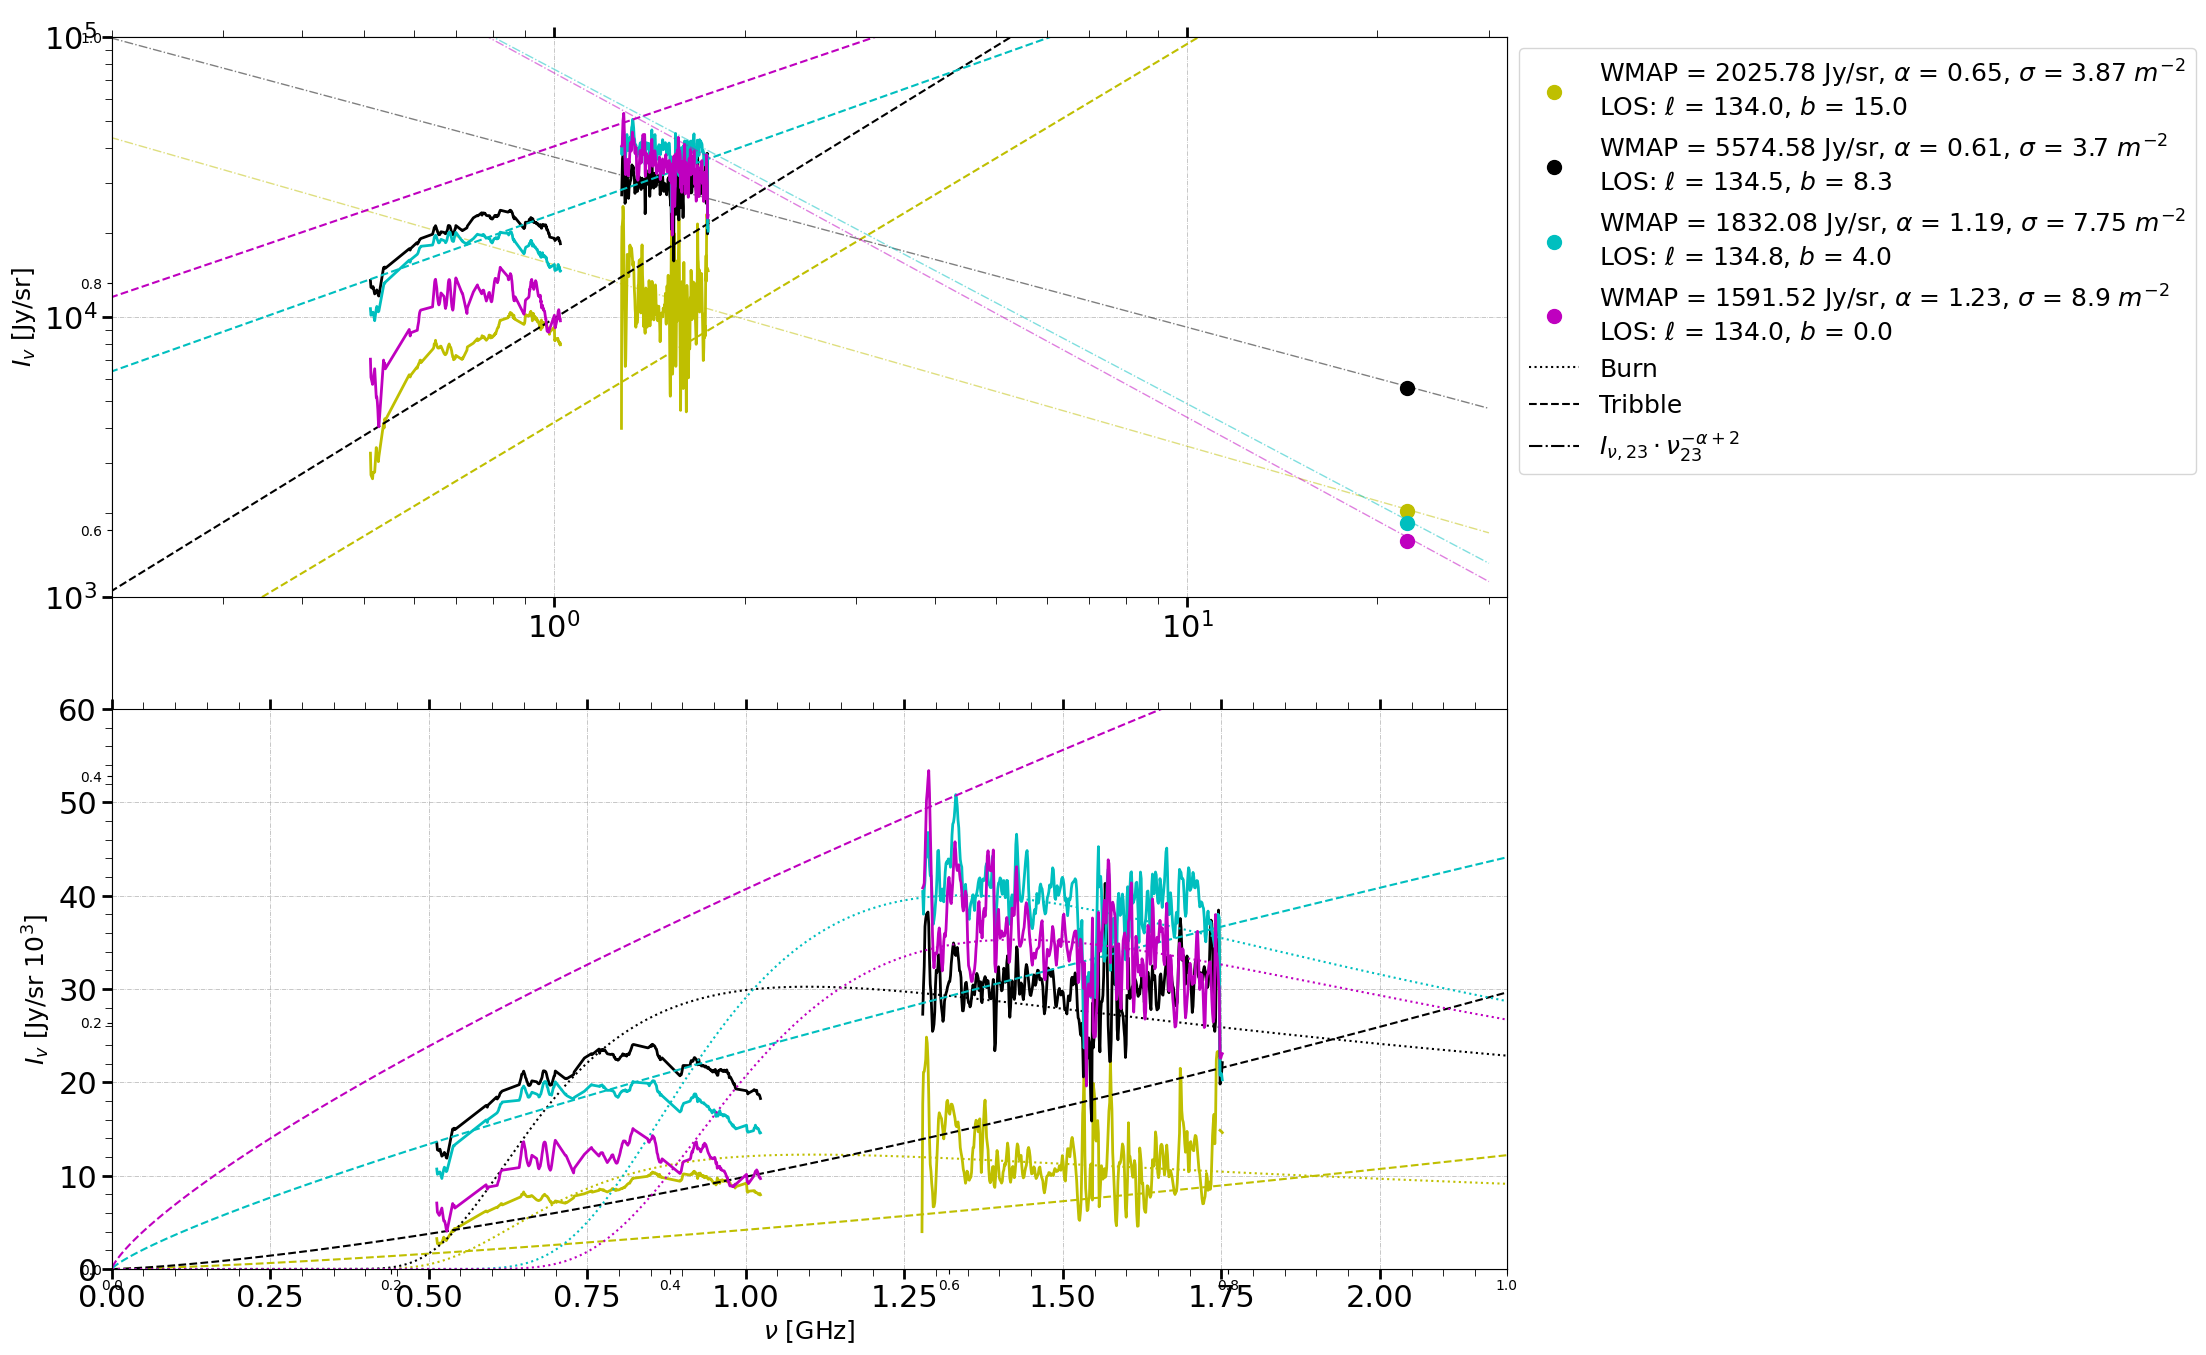

In [25]:
fig = plt.figure(figsize=(18,16))
ax = fig.add_subplot(111)
all_v = np.arange(1e-3, 30, 1e-3)
ax = fig.add_subplot(211)
ax2= fig.add_subplot(212)

for c, color in zip(clist, ['y', 'k', 'c', 'm']):

    beam_gmims = gmims_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                  ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)
    gmims_spectrum_K = np.median(beam_gmims.with_mask(beam_gmims>0.05*u.K).median(axis=1).value, axis=1)*beam_gmims.unit
    gmims_spectrum_Jy_sr = gmims_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(beam_gmims.spectral_axis))

    beam_drago = drago_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                    ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)/u.Jy*u.beam*u.K
    drago_spectrum_K = np.median(beam_drago.with_mask(beam_drago>0.05*u.K).median(axis=1).value, axis=1)*beam_drago.unit
    drago_spectrum_Jy_sr = drago_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(drag_freq*u.Hz))

    full_v=np.concatenate(((drag_freq*u.Hz).to(u.GHz).value,beam_gmims.spectral_axis.to(u.GHz).value))
    full_Iv = np.concatenate((drago_spectrum_Jy_sr, gmims_spectrum_Jy_sr))

    nan_mask = ~np.isnan(full_v) & ~np.isnan(full_Iv)
    filtered_Hz = full_v[nan_mask]
    filtered_Iv = full_Iv[nan_mask]
    
    pop2, pcov = curve_fit(burn_depol,filtered_Hz,filtered_Iv, bounds=([0,0], [np.inf, np.inf]), p0=[3, 1])
    pop3, pcov = curve_fit(tribble_depol,filtered_Hz,filtered_Iv, bounds=([0,0, 0], [np.inf, np.inf, np.inf]))
    [alphafit, sigmafit] = pop2
    N=pop3[2]
    wmap=wmap_pI[int((wcs_hbn.wcs_world2pix((c.l.value),c.b.value, 1, 1))[0]),int((wcs_hbn.wcs_world2pix((c.l.value),c.b.value, 1, 1))[1])].to(u.Jy/u.sr, equivalencies=u.brightness_temperature(np.asarray([22.8])*u.GHz)).value
    print(f'WMAP Held, alpha = {pop2[0]}, sigma={pop2[1]}')
    print(f'WMAP free, alpha = {alphafit}, sigma={sigmafit}')
    
    #ax.plot(all_v, tribble_depol_wmapheld(all_v, alphafit, sigmafit, N), ls='--', c=color)
    #ax.plot(all_v, burn_depol_wmapheld(all_v, *pop2), ls='dotted', c=color)#ax.plot(all_v, powerlaw(all_v, wmapfit, alphafit), ls='--', c='y', label='No Depol')
    ax.plot(all_v, powerlaw(all_v, alphafit), ls='-.', c=color, lw=1, alpha=0.5)
    ax.plot(all_v, tribble_depol(all_v, alphafit, sigmafit, N), ls='--', c=color)
    ax.scatter([],[],s=100,c=color,
               label=fr'WMAP = {round(wmap[0], 2)} Jy/sr, $\alpha$ = {round(alphafit, 2)}, $\sigma$ = {round(sigmafit, 2)}' +r' $m^{-2}$' + '\n' + fr'LOS: $\ell$ = {round(c.galactic.l.value,2)}, $b$ = {round(c.galactic.b.value,2)}')
 
    ax.plot(beam_gmims.spectral_axis.to(u.GHz), gmims_spectrum_Jy_sr, c=color, lw=2)
    ax.plot((drag_freq*u.Hz).to(u.GHz), drago_spectrum_Jy_sr, c=color, lw=2)
    
    ax.scatter(22.28, wmap, c=color, s=100)
    
    ax2.plot(all_v, tribble_depol(all_v, alphafit, sigmafit, N)/1e3, ls='--', c=color)
    ax2.plot(all_v, burn_depol(all_v, *pop2)/1e3, ls='dotted', c=color)#ax.plot(all_v, powerlaw(all_v, wmapfit, alphafit), ls='--', c='y', label='No Depol')
               
    ax2.plot((drag_freq*u.Hz).to(u.GHz), drago_spectrum_Jy_sr/1e3, c=color, lw=2)
    ax2.plot(beam_gmims.spectral_axis.to(u.GHz), gmims_spectrum_Jy_sr/1e3, c=color, lw=2)
    
    


ax.set_ylabel(r'$I_v$ [Jy/sr]', fontsize=18)
#ax.set_xlabel(r'$\nu$ [GHz]', fontsize=18)
#ax.set_ylim(0,6e4)
#ax.set_xlim(0.2e9)
ax.plot([],[],ls=':', label='Burn', c='k')
ax.plot([], [],ls='--', label='Tribble', c='k')
ax.plot([], [],ls='-.', label=r'$I_{\nu,23} \cdot \nu_{23}^{-\alpha+2}$', c='k')
ax.set_ylim(1000,100000)
ax.set_xlim(0.2, 32)#32)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(' ', fontsize=18)
ax.minorticks_on()  # Enable minor ticks for the first subplot
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
ax.legend(fontsize=18,ncol=1, loc='center left', bbox_to_anchor=(1, 0.6))

ax2.set_ylabel(r'$I_v$ [Jy/sr $10^{3}$]', fontsize=18)
ax2.set_xlabel(r'$\nu$ [GHz]', fontsize=18)
#ax.set_ylim(0,6e4)
#ax.set_xlim(0.2e9)
ax2.set_ylim(0, 60)
ax2.set_xlim(0, 2.2)#32)
#ax2.set_xscale('log')
#plt.xscale('log')
ax2.set_title(' ', fontsize=20)
ax2.minorticks_on()  # Enable minor ticks for the first subplot
ax2.grid(which='major', linestyle='-.', linewidth=0.5)
ax2.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax2.tick_params(axis='both', which='minor', length=5, top=True)
#ax2.legend(fontsize=14,ncol=1, loc='center left', bbox_to_anchor=(1, 0.7))

WMAP Held, alpha = 0.6576615032187886, sigma=3.3649712881612044
WMAP free, alpha = 0.6576615032187886, sigma=3.3649712881612044
WMAP Held, alpha = 0.5486916724693688, sigma=2.031876048765461
WMAP free, alpha = 0.5486916724693688, sigma=2.031876048765461
WMAP Held, alpha = 1.1339604268921328, sigma=4.059720890561607
WMAP free, alpha = 1.1339604268921328, sigma=4.059720890561607
WMAP Held, alpha = 1.1530579074723786, sigma=4.6657927256994345
WMAP free, alpha = 1.1530579074723786, sigma=4.6657927256994345


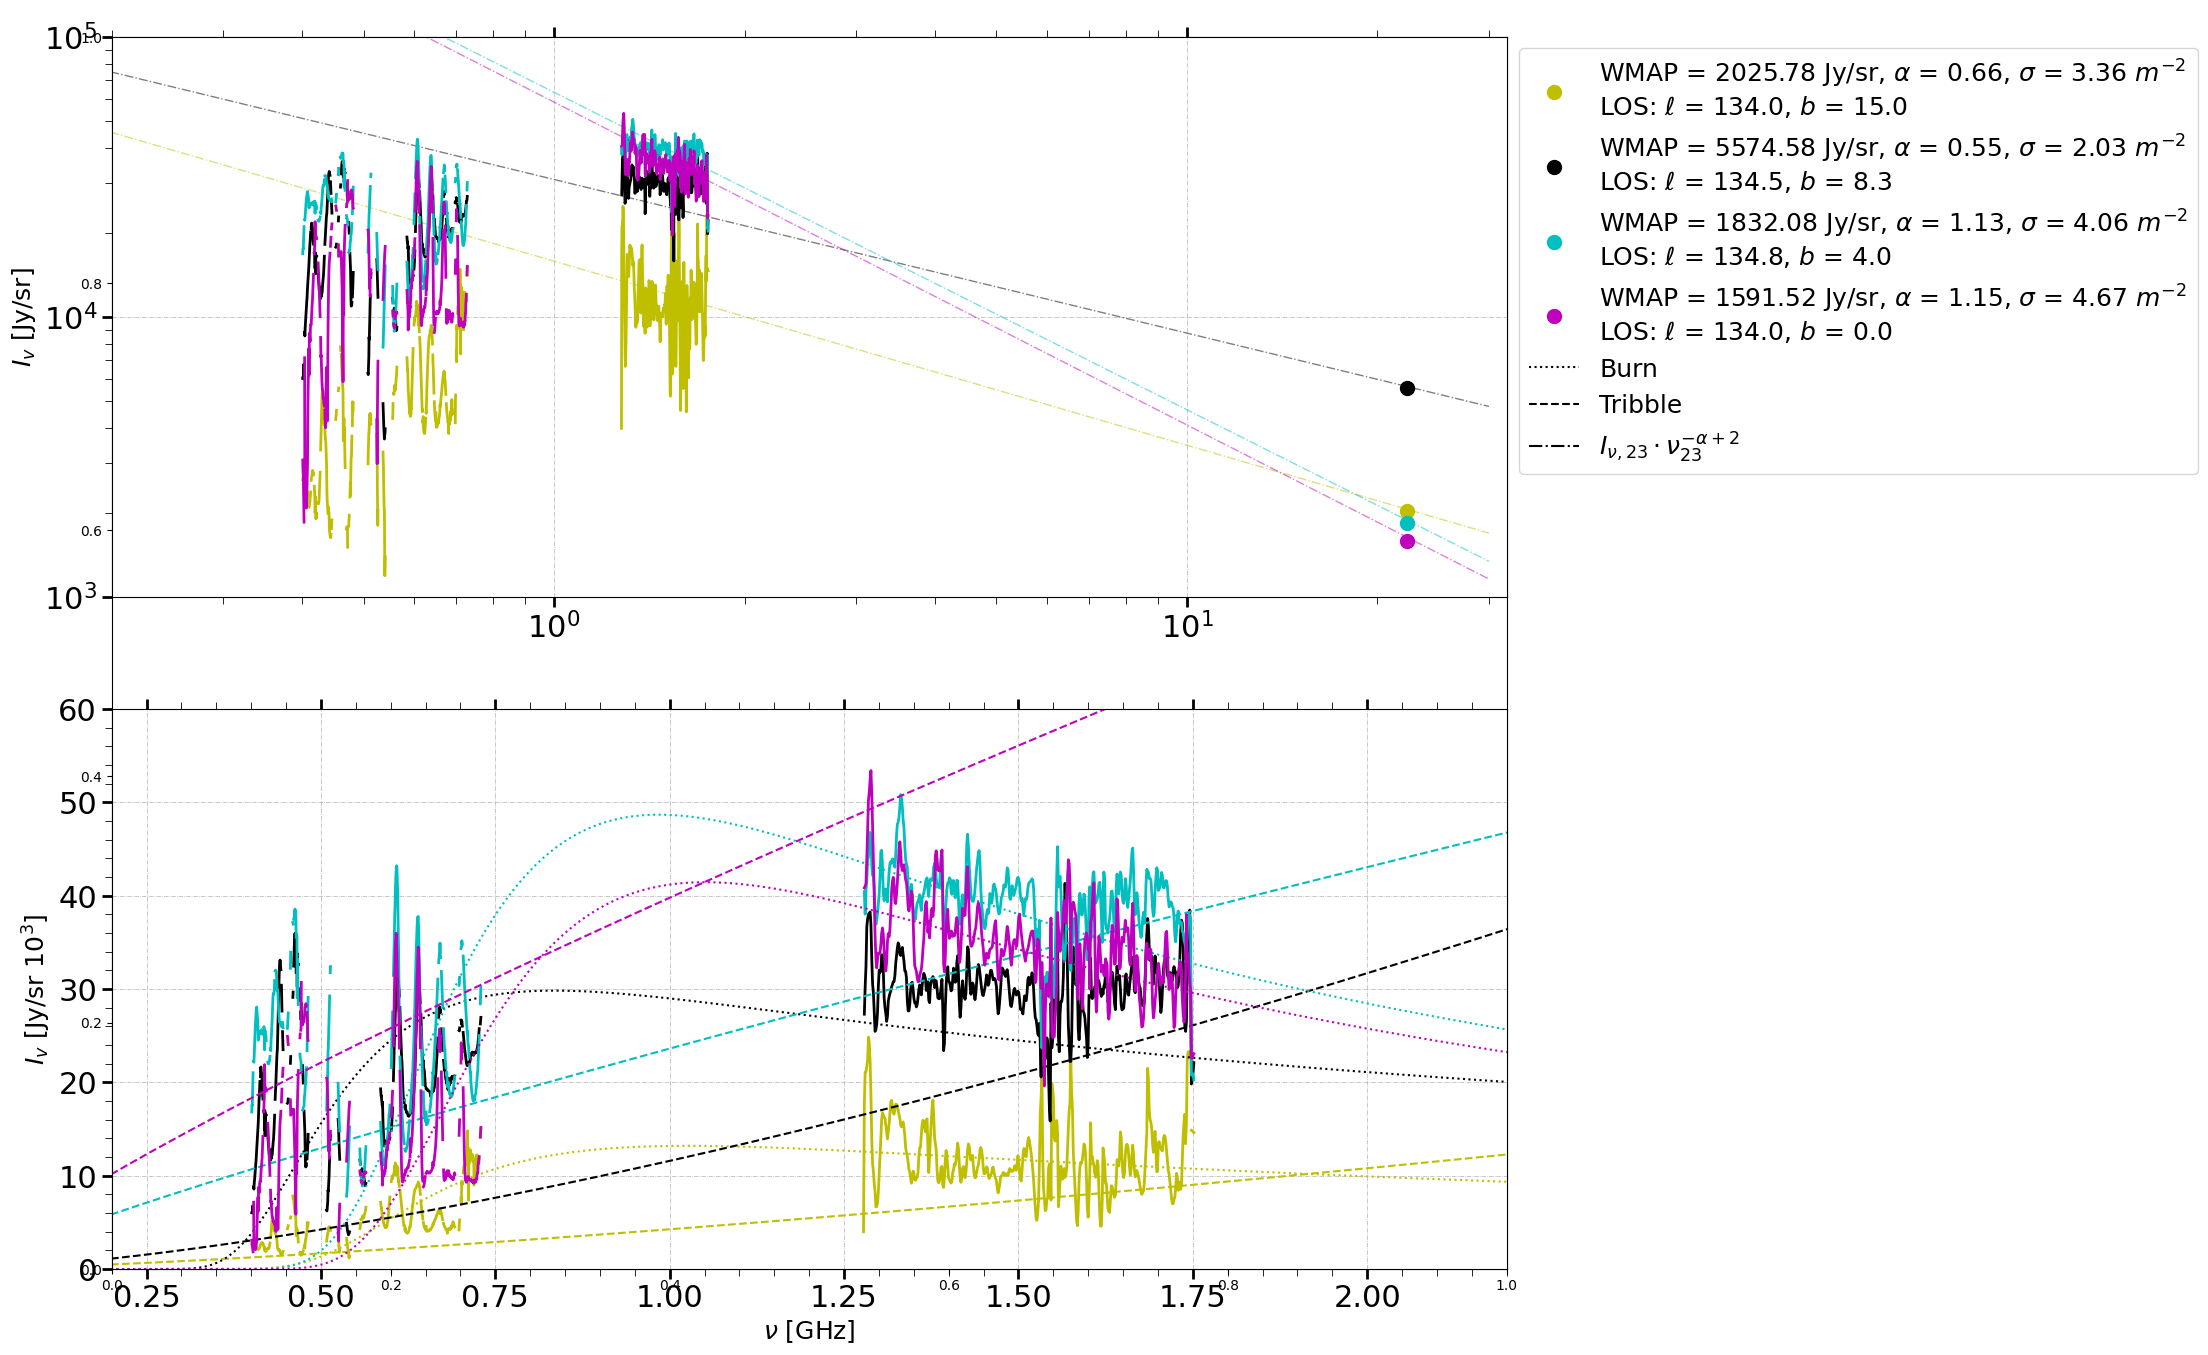

In [69]:
fig = plt.figure(figsize=(18,16))
ax = fig.add_subplot(111)
all_v = np.arange(1e-3, 30, 1e-3)
ax = fig.add_subplot(211)
ax2= fig.add_subplot(212)

for c, color in zip(clist, ['y', 'k', 'c', 'm']):

    beam_gmims = gmims_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                    ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)
    gmims_spectrum_K = np.median(beam_gmims.with_mask(beam_gmims>0.05*u.K).median(axis=1).value, axis=1)*beam_gmims.unit
    gmims_spectrum_Jy_sr = gmims_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(beam_gmims.spectral_axis))

    beam_chime = chime_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                    ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)*u.K
    chime_spectrum_K = np.median(beam_chime.with_mask(beam_chime>0.05*u.K).median(axis=1).value, axis=1)*beam_chime.unit
    chime_spectrum_Jy_sr = chime_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(beam_chime.spectral_axis))

    full_v=np.concatenate((beam_chime.spectral_axis.to(u.GHz).value,beam_gmims.spectral_axis.to(u.GHz).value))
    full_Iv = np.concatenate((chime_spectrum_Jy_sr, gmims_spectrum_Jy_sr))

    nan_mask = ~np.isnan(full_v) & ~np.isnan(full_Iv)
    filtered_Hz = full_v[nan_mask]
    filtered_Iv = full_Iv[nan_mask]
    
    pop2, pcov = curve_fit(burn_depol,filtered_Hz,filtered_Iv, bounds=([0,0], [np.inf, np.inf]), p0=[3, 1])
    pop3, pcov = curve_fit(tribble_depol,filtered_Hz,filtered_Iv, bounds=([0,0, 0], [np.inf, np.inf, np.inf]))
    [alphafit, sigmafit] = pop2
    N=pop3[2]
    wmap=wmap_pI[int((wcs_hbn.wcs_world2pix((c.l.value),c.b.value, 1, 1))[0]),int((wcs_hbn.wcs_world2pix((c.l.value),c.b.value, 1, 1))[1])].to(u.Jy/u.sr, equivalencies=u.brightness_temperature(np.asarray([22.8])*u.GHz)).value
    print(f'WMAP Held, alpha = {pop2[0]}, sigma={pop2[1]}')
    print(f'WMAP free, alpha = {alphafit}, sigma={sigmafit}')
    
    ax.plot(all_v, powerlaw(all_v, alphafit), ls='-.', c=color, lw=1, alpha=0.5)
    ax.scatter([],[],s=100,c=color,
               label=fr'WMAP = {round(wmap[0], 2)} Jy/sr, $\alpha$ = {round(alphafit, 2)}, $\sigma$ = {round(sigmafit, 2)}' +r' $m^{-2}$' + '\n' + fr'LOS: $\ell$ = {round(c.galactic.l.value,2)}, $b$ = {round(c.galactic.b.value,2)}')
 
    ax.plot(beam_gmims.spectral_axis.to(u.GHz), gmims_spectrum_Jy_sr, c=color, lw=2)
    ax.plot((beam_chime.spectral_axis).to(u.GHz), chime_spectrum_Jy_sr, c=color, lw=2)
    ax.scatter(22.28, wmap, c=color, s=100)
    
    ax2.plot(all_v, tribble_depol(all_v, alphafit, sigmafit, N)/1e3, ls='--', c=color)
    ax2.plot(all_v, burn_depol(all_v, *pop2)/1e3, ls='dotted', c=color)#ax.plot(all_v, powerlaw(all_v, wmapfit, alphafit), ls='--', c='y', label='No Depol')
               
    ax2.plot((beam_chime.spectral_axis).to(u.GHz), chime_spectrum_Jy_sr/1e3, c=color, lw=2)
    ax2.plot(beam_gmims.spectral_axis.to(u.GHz), gmims_spectrum_Jy_sr/1e3, c=color, lw=2)
    
    


ax.set_ylabel(r'$I_v$ [Jy/sr]', fontsize=18)
#ax.set_xlabel(r'$\nu$ [GHz]', fontsize=18)
#ax.set_ylim(0,6e4)
#ax.set_xlim(0.2e9)
ax.plot([],[],ls=':', label='Burn', c='k')
ax.plot([], [],ls='--', label='Tribble', c='k')
ax.plot([], [],ls='-.', label=r'$I_{\nu,23} \cdot \nu_{23}^{-\alpha+2}$', c='k')
ax.set_ylim(1000,100000)
ax.set_xlim(0.2, 32)#32)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(' ', fontsize=18)
ax.minorticks_on()  # Enable minor ticks for the first subplot
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
ax.legend(fontsize=18,ncol=1, loc='center left', bbox_to_anchor=(1, 0.6))

ax2.set_ylabel(r'$I_v$ [Jy/sr $10^{3}$]', fontsize=18)
ax2.set_xlabel(r'$\nu$ [GHz]', fontsize=18)
#ax.set_ylim(0,6e4)
#ax.set_xlim(0.2e9)
ax2.set_ylim(0, 60)
ax2.set_xlim(0.2, 2.2)#32)
#ax2.set_xscale('log')
#plt.xscale('log')
ax2.set_title(' ', fontsize=20)
ax2.minorticks_on()  # Enable minor ticks for the first subplot
ax2.grid(which='major', linestyle='-.', linewidth=0.5)
ax2.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax2.tick_params(axis='both', which='minor', length=5, top=True)
#ax2.legend(fontsize=14,ncol=1, loc='center left', bbox_to_anchor=(1, 0.7))